# Color Spaces

In this notebook, we will explore how colormaps move through two colorspaces, specifically [HSV](https://en.wikipedia.org/wiki/HSL_and_HSV) and RGB.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import IPython.display
import io
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import ipywidgets
plt.rcParams["figure.figsize"] = (16, 12)

The next cell is going to set up two different functions.  One will take rgb values and rotate them through RGB space, and the other will plot a nice depiction of the colormap in RGB space.

In [3]:
def rotate(arr, theta, phi, psi):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), np.sin(phi)],
                   [0.0, -np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, -np.sin(theta)],
                   [0.0, 1.0, 0.0],
                  [np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), np.sin(psi), 0],
                  [-np.sin(psi), np.cos(psi), 0],
                  [0, 0, 1]])
    R = np.dot(Rx, Ry).dot(Rz)
    return np.dot(arr - 0.5, R) + 0.5
    
    
def plot_colortable(colortable, theta = 0.0, phi = 0.0, psi = 0.0):
    title = ""
    if isinstance(colortable, str):
        title = title or colortable
        colortable = matplotlib.cm.cmap_d[colortable](np.mgrid[0.0:1.0:256j])
    colortable = rotate(colortable[:,:3], theta, phi, psi)
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_axes([0.0, 0.25, 0.75, 0.75], projection="3d")
    ax.plot(colortable[:,0], colortable[:,1], colortable[:,2], '-', lw=4)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_zlim(-0.05, 1.05)
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    
    ax = fig.add_axes([0.75, 0.76, 0.25, 0.20])
    ax.plot(colortable[:,0], colortable[:,1], '-', lw=4)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Red", fontsize=18)
    ax.set_ylabel("Green", fontsize=18)

    ax = fig.add_axes([0.75, 0.52, 0.25, 0.20])
    ax.plot(colortable[:,0], colortable[:,2], '-', lw=4)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Red", fontsize=18)
    ax.set_ylabel("Blue", fontsize=18)
    
    ax = fig.add_axes([0.75, 0.28, 0.25, 0.20])
    ax.plot(colortable[:,1], colortable[:,2], '-', lw=4)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.095)
    ax.set_xlabel("Green", fontsize=18)
    ax.set_ylabel("Blue", fontsize=18)

    # Now we do three colorbars that span the whole thing
    
    im = np.ones((16, colortable.shape[0], 4), dtype="uint8")
    im[...,:3] = (colortable * 255).astype("uint8")[None,:,:]
    im[...,3] = 255
    im_no_red = im.copy()
    im_no_red[:,:,0] = 0
    
    im_no_green = im.copy()
    im_no_green[:,:,1] = 0
    
    im_no_blue = im.copy()
    im_no_blue[:,:,2] = 0

    aspect = im.shape[0]/im.shape[1] * 10
    
    ax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
    ax.imshow(im, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("Standard", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)

    ax = fig.add_axes([0.0, 0.06, 1.0, 0.05])
    ax.imshow(im_no_red, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Red", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    ax = fig.add_axes([0.0, 0.12, 1.0, 0.05])
    ax.imshow(im_no_green, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Green", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    ax = fig.add_axes([0.0, 0.18, 1.0, 0.05])
    ax.imshow(im_no_blue, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Blue", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    if title is not None:
        fig.suptitle(title, fontsize = 24)

Let's create a widget, and see what our colormaps look like in those dimensions.

In [4]:
ipywidgets.interact(plot_colortable, colortable = ["viridis", "jet", "RdBu", "Blues"],
                   theta = (0.0, 2.0*np.pi, 0.01), phi = (0.0, 2.0*np.pi, 0.01), psi = (0.0, 2.0*np.pi, 0.01))

interactive(children=(Dropdown(description='colortable', options=('viridis', 'jet', 'RdBu', 'Blues'), value='viridis'), FloatSlider(value=0.0, description='theta', max=6.2831853071795862, step=0.01), FloatSlider(value=0.0, description='phi', max=6.2831853071795862, step=0.01), FloatSlider(value=0.0, description='psi', max=6.2831853071795862, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_colortable>

A better representation of this would be in HSV space.  Here we convert from RGB to HSV, which can be a tricky process.  Note that HSV space is periodic in Hue, so we can rotate around the axis and it will remain continous.

In [7]:
def move_cylinder(arr, theta, phi, psi):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(phi), np.sin(phi)],
                   [0.0, -np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, -np.sin(theta)],
                   [0.0, 1.0, 0.0],
                  [np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), np.sin(psi), 0],
                  [-np.sin(psi), np.cos(psi), 0],
                  [0, 0, 1]])
    R = np.dot(Rx, Ry).dot(Rz)
    return np.dot(arr - 0.5, R) + 0.5

def rgb_to_hsv(arr):
    # https://en.wikipedia.org/wiki/HSL_and_HSV has info; we will use C_2 and H_2
    # The colortable is in the range 0..1.
    alpha = 0.5 * (2*arr[...,0] - arr[...,1] - arr[...,2])
    beta = np.sqrt(3)/2.0 * (arr[...,1] - arr[...,2])
    H2 = np.arctan2(beta, alpha)
    H2[H2<0] += 2.0 * np.pi
    C2 = np.sqrt(alpha**2 + beta**2)
    ma = np.max(arr, axis=-1)
    mi = np.min(arr, axis=-1)
    V = ma
    S = C2/V
    np.nan_to_num(S)
    return np.stack([H2, S, V], axis=-1)

def hsv_to_rgb(arr):
    # H, S, V
    C = arr[...,2] * arr[...,1]
    Hp = arr[...,0] / (np.pi/3)
    
    X = C * (1.0 - np.abs(np.mod(Hp, 2) - 1))
    c1 = (0 <= Hp) & (Hp < 1)
    c2 = (1 <= Hp) & (Hp < 2)
    c3 = (2 <= Hp) & (Hp < 3)
    c4 = (3 <= Hp) & (Hp < 4)
    c5 = (4 <= Hp) & (Hp < 5)
    c6 = (5 <= Hp) & (Hp <= 6)

    rgb = np.zeros_like(arr)
    rgb[c1,0] = C[c1]
    rgb[c1,1] = X[c1]
    rgb[c1,2] = 0
    
    rgb[c2,0] = X[c2]
    rgb[c2,1] = C[c2]
    rgb[c2,2] = 0
    
    rgb[c3,0] = 0
    rgb[c3,1] = C[c3]
    rgb[c3,2] = X[c3]
    
    rgb[c4,0] = 0
    rgb[c4,1] = X[c4]
    rgb[c4,2] = C[c4]
    
    rgb[c5,0] = X[c5]
    rgb[c5,1] = 0
    rgb[c5,2] = C[c5]
    
    rgb[c6,0] = C[c6]
    rgb[c6,1] = 0
    rgb[c6,2] = X[c6]
    
    mi = arr[...,2] - C
    
    rgb += mi[...,None]
    
    return rgb

def plot_colortable_hsv(colortable, hue_theta = 0.0, sat_scale = 1.0, val_scale = 1.0, name = None):
    title = ""
    if isinstance(colortable, str):
        title = title or colortable
        colortable = matplotlib.cm.cmap_d[colortable](np.mgrid[0.0:1.0:256j])
    HSV = rgb_to_hsv(colortable[...,:3])
    
    # Now we scale and rotate
    angle = hue_theta + HSV[...,0]
    HSV[...,0] = angle - 2.0*np.pi * np.floor(angle / (2.0*np.pi))
    HSV[...,1] = np.clip(sat_scale * HSV[...,1], 0.0, 1.0)
    HSV[...,2] = np.clip(val_scale * HSV[...,2], 0.0, 1.0)
    
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_axes([0.0, 0.25, 0.75, 0.75], projection="3d")
    x = HSV[...,1] * np.cos(HSV[...,0])
    y = HSV[...,1] * np.sin(HSV[...,0])
    z = HSV[...,2]
    ax.plot(x, y, z, '.-', markevery=10, lw=4, ms=16)
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.set_zlim(-0.05, 1.05)
    ax.set_xlabel("Hue")
    ax.set_ylabel("Saturation")
    ax.set_zlabel("Value")
    
    ax = fig.add_axes([0.75, 0.76, 0.25, 0.20], projection="polar")
    ax.plot(HSV[:,0], HSV[:,1], '.-', markevery=10, lw=4, ms=16)
    ax.set_xlim(-0.05, 2.0*np.pi + 0.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title("Saturation", fontsize=18)

    ax = fig.add_axes([0.75, 0.52, 0.25, 0.20])
    ax.plot(HSV[:,0], HSV[:,2], '.-', markevery=10, lw=4, ms=16)
    ax.set_xlim(-0.05, 2.0*np.pi + 0.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title("Value", fontsize=18)
    
    ax = fig.add_axes([0.75, 0.28, 0.25, 0.20])
    ax.plot(HSV[:,1], HSV[:,2], '.-', markevery=10, lw=4, ms=16)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.095)
    ax.set_xlabel("Saturation", fontsize=18)
    ax.set_ylabel("Value", fontsize=18)

    # Now we do three colorbars that span the whole thing
    
    colortable = hsv_to_rgb(HSV)
    
    im = np.ones((16, colortable.shape[0], 4), dtype="uint8")
    im[...,:3] = (colortable * 255).astype("uint8")[None,:,:]
    im[...,3] = 255
    im_no_red = im.copy()
    im_no_red[:,:,0] = 0
    
    im_no_green = im.copy()
    im_no_green[:,:,1] = 0
    
    im_no_blue = im.copy()
    im_no_blue[:,:,2] = 0

    aspect = im.shape[0]/im.shape[1] * 10
    
    ax = fig.add_axes([0.0, 0.0, 1.0, 0.05])
    ax.imshow(im, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("Standard", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)

    ax = fig.add_axes([0.0, 0.06, 1.0, 0.05])
    ax.imshow(im_no_red, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Red", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    ax = fig.add_axes([0.0, 0.12, 1.0, 0.05])
    ax.imshow(im_no_green, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Green", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    ax = fig.add_axes([0.0, 0.18, 1.0, 0.05])
    ax.imshow(im_no_blue, interpolation='nearest', aspect = aspect)
    ax.set_ylabel("No Blue", fontsize=16)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    
    if title is not None:
        fig.suptitle(title, fontsize = 24)
        
    if name is not None:
        plt.savefig(name)

In [6]:
ipywidgets.interact(plot_colortable_hsv, colortable = ["viridis", "jet", "gray", "gist_stern", "flag", "magma"],
                    hue_theta = (-1.0*np.pi, 1.0*np.pi, 0.01),
                    sat_scale = (0.01, 10.0, 0.01),
                    val_scale = (0.01, 10.0, 0.01))

interactive(children=(Dropdown(description='colortable', options=('viridis', 'jet', 'gray', 'gist_stern', 'flag', 'magma'), value='viridis'), FloatSlider(value=0.0, description='hue_theta', max=3.1415926535897931, min=-3.1415926535897931, step=0.01), FloatSlider(value=1.0, description='sat_scale', max=10.0, min=0.01, step=0.01), FloatSlider(value=1.0, description='val_scale', max=10.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_colortable_hsv>

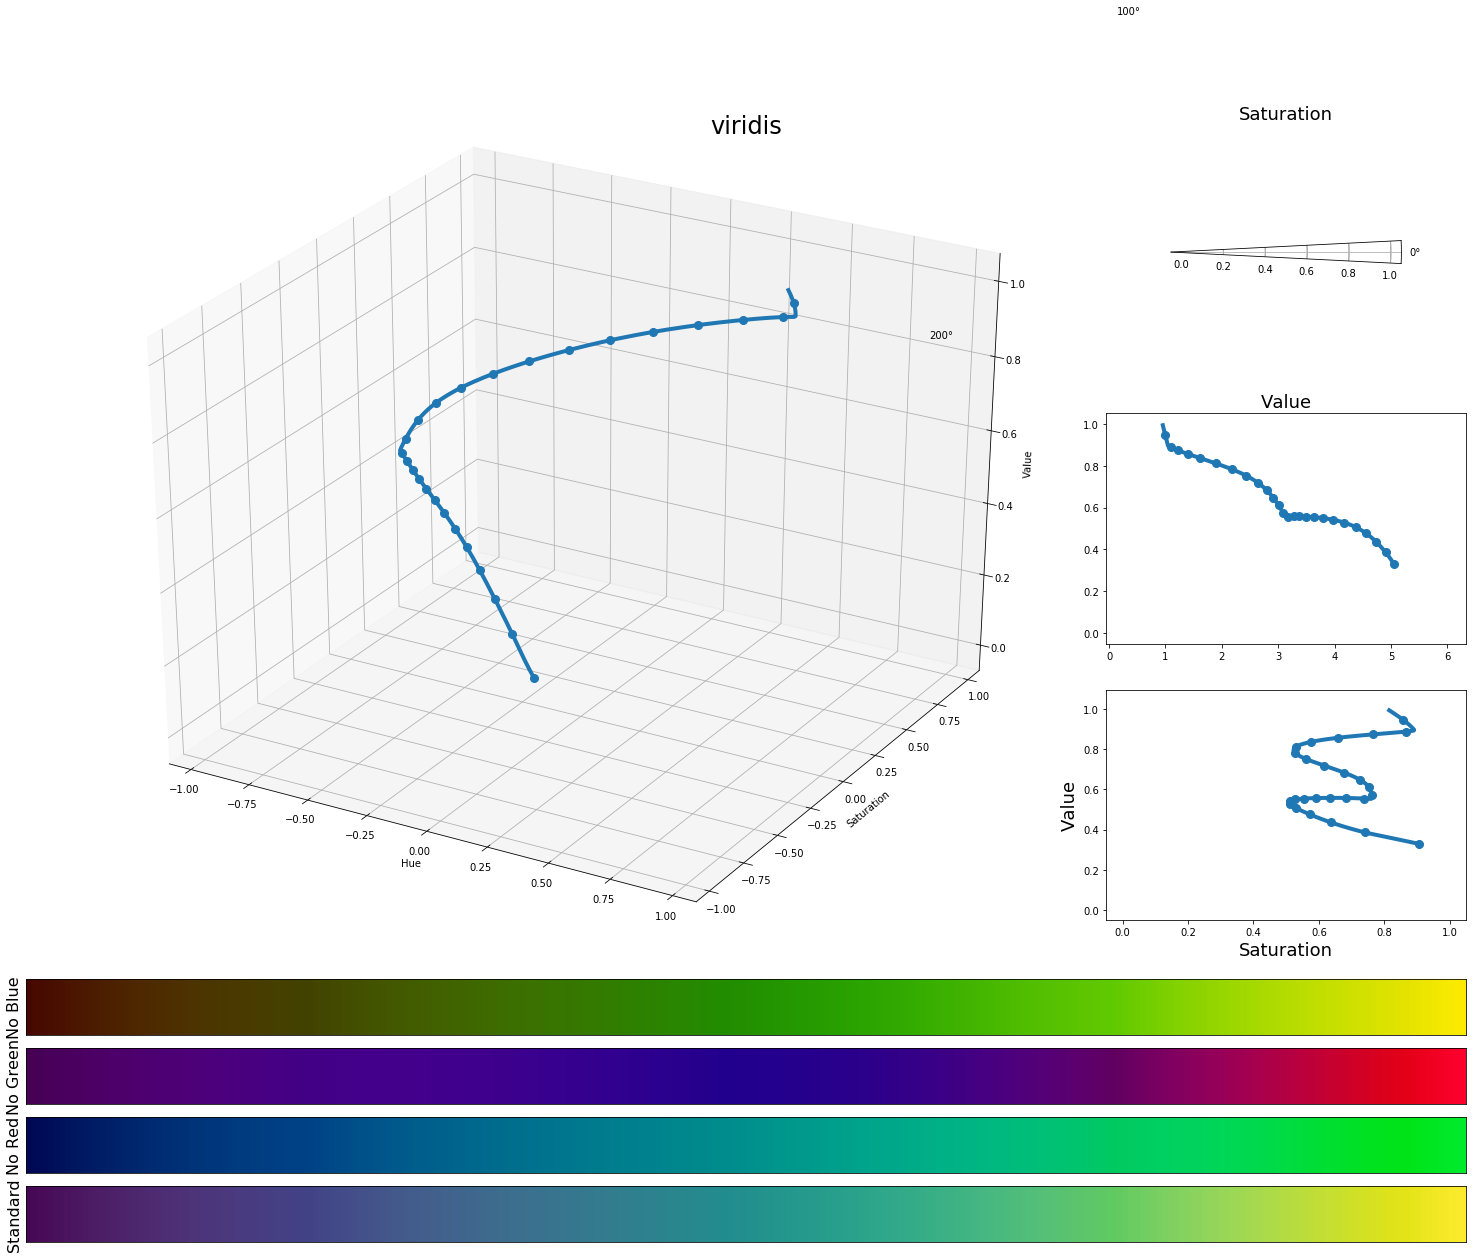

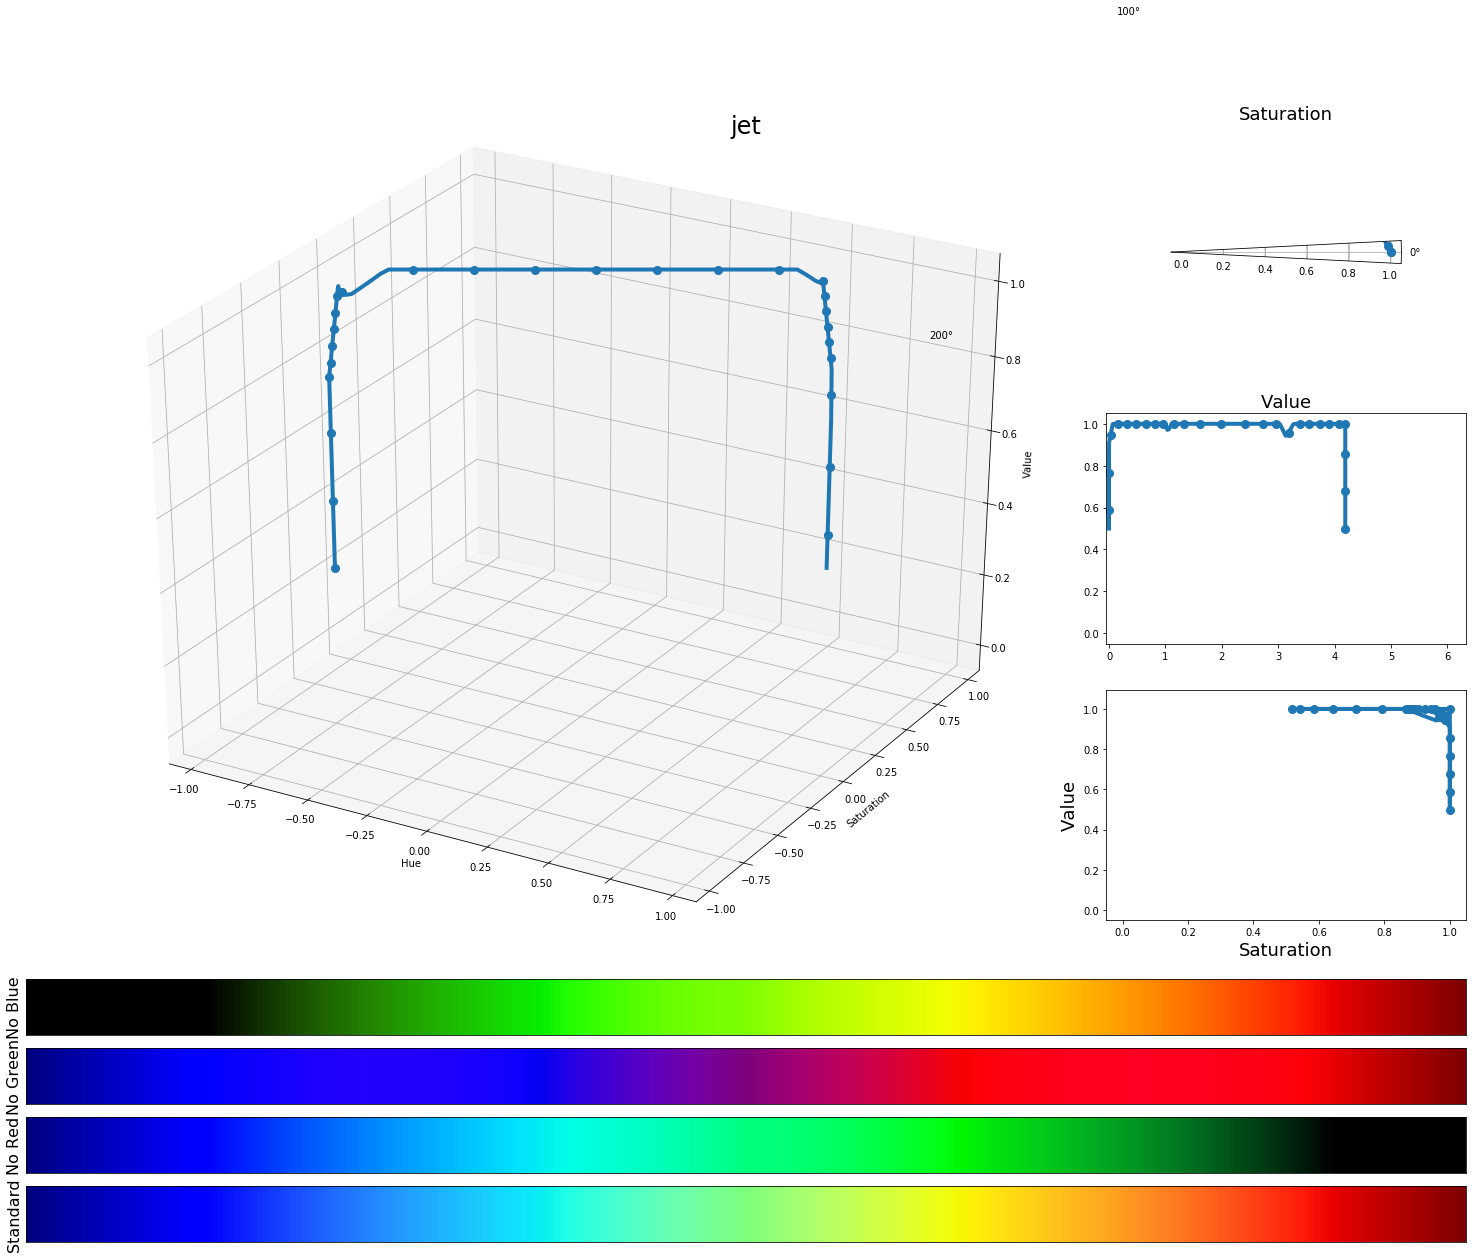

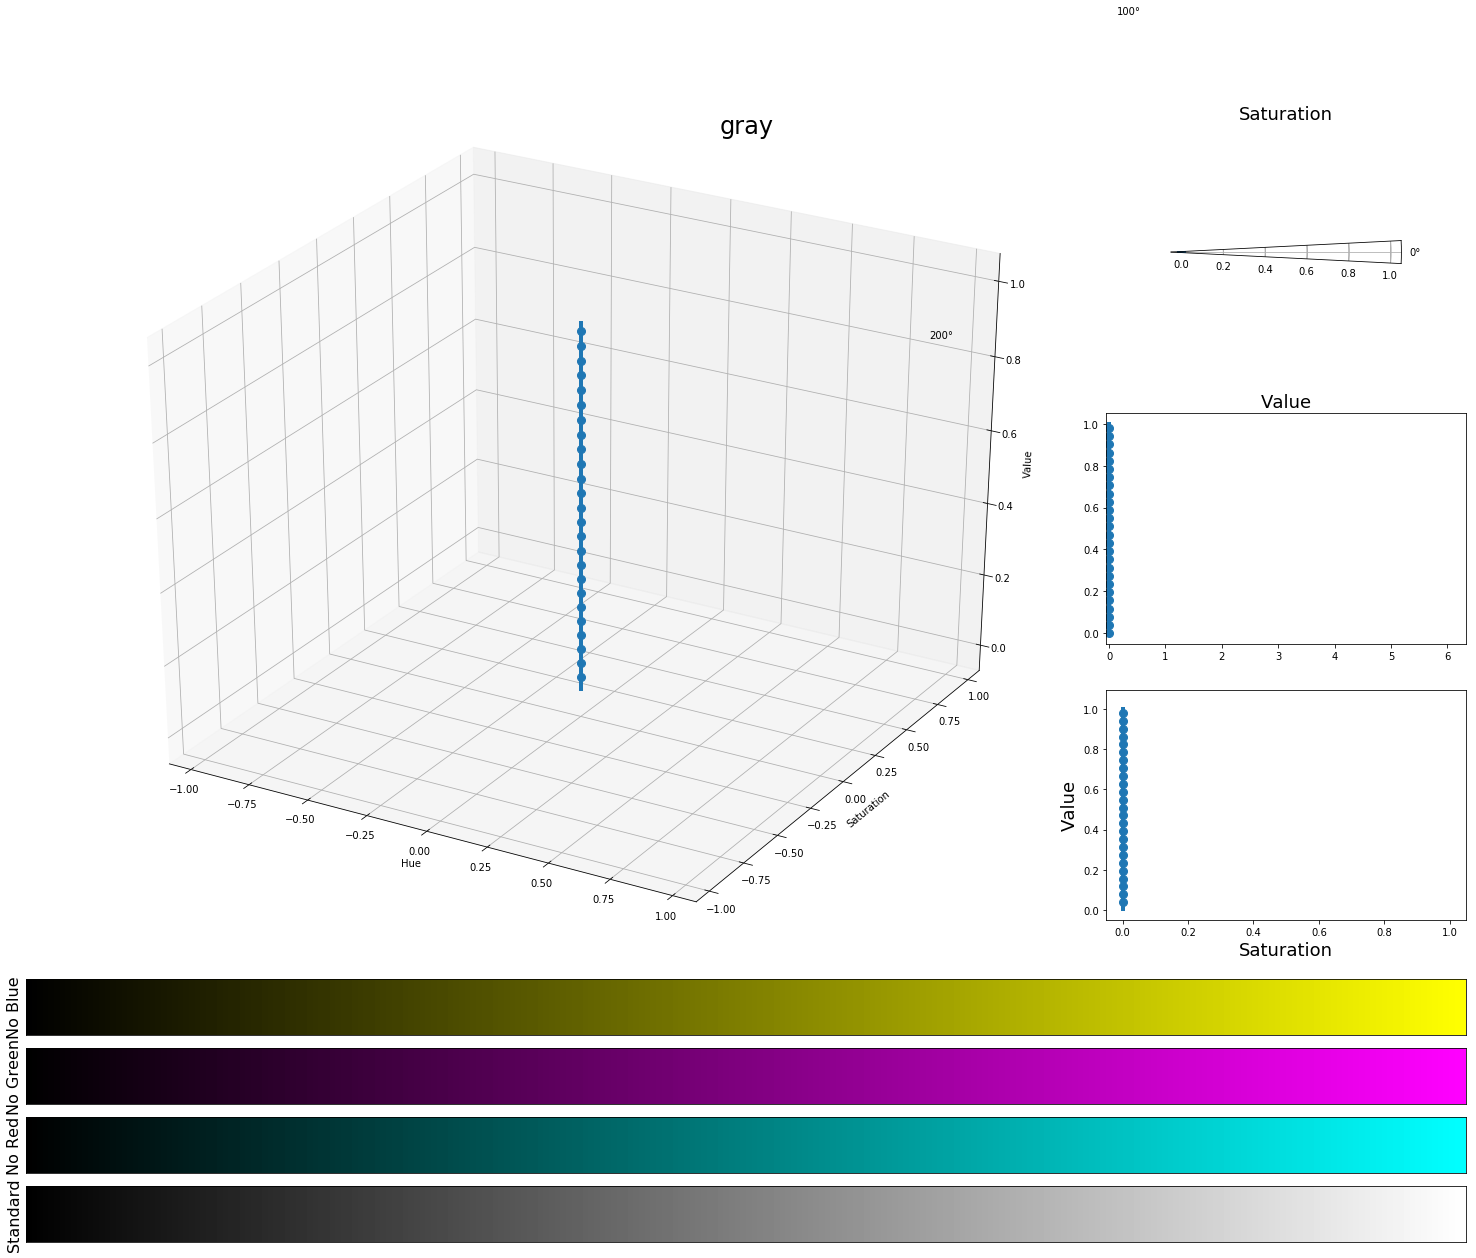

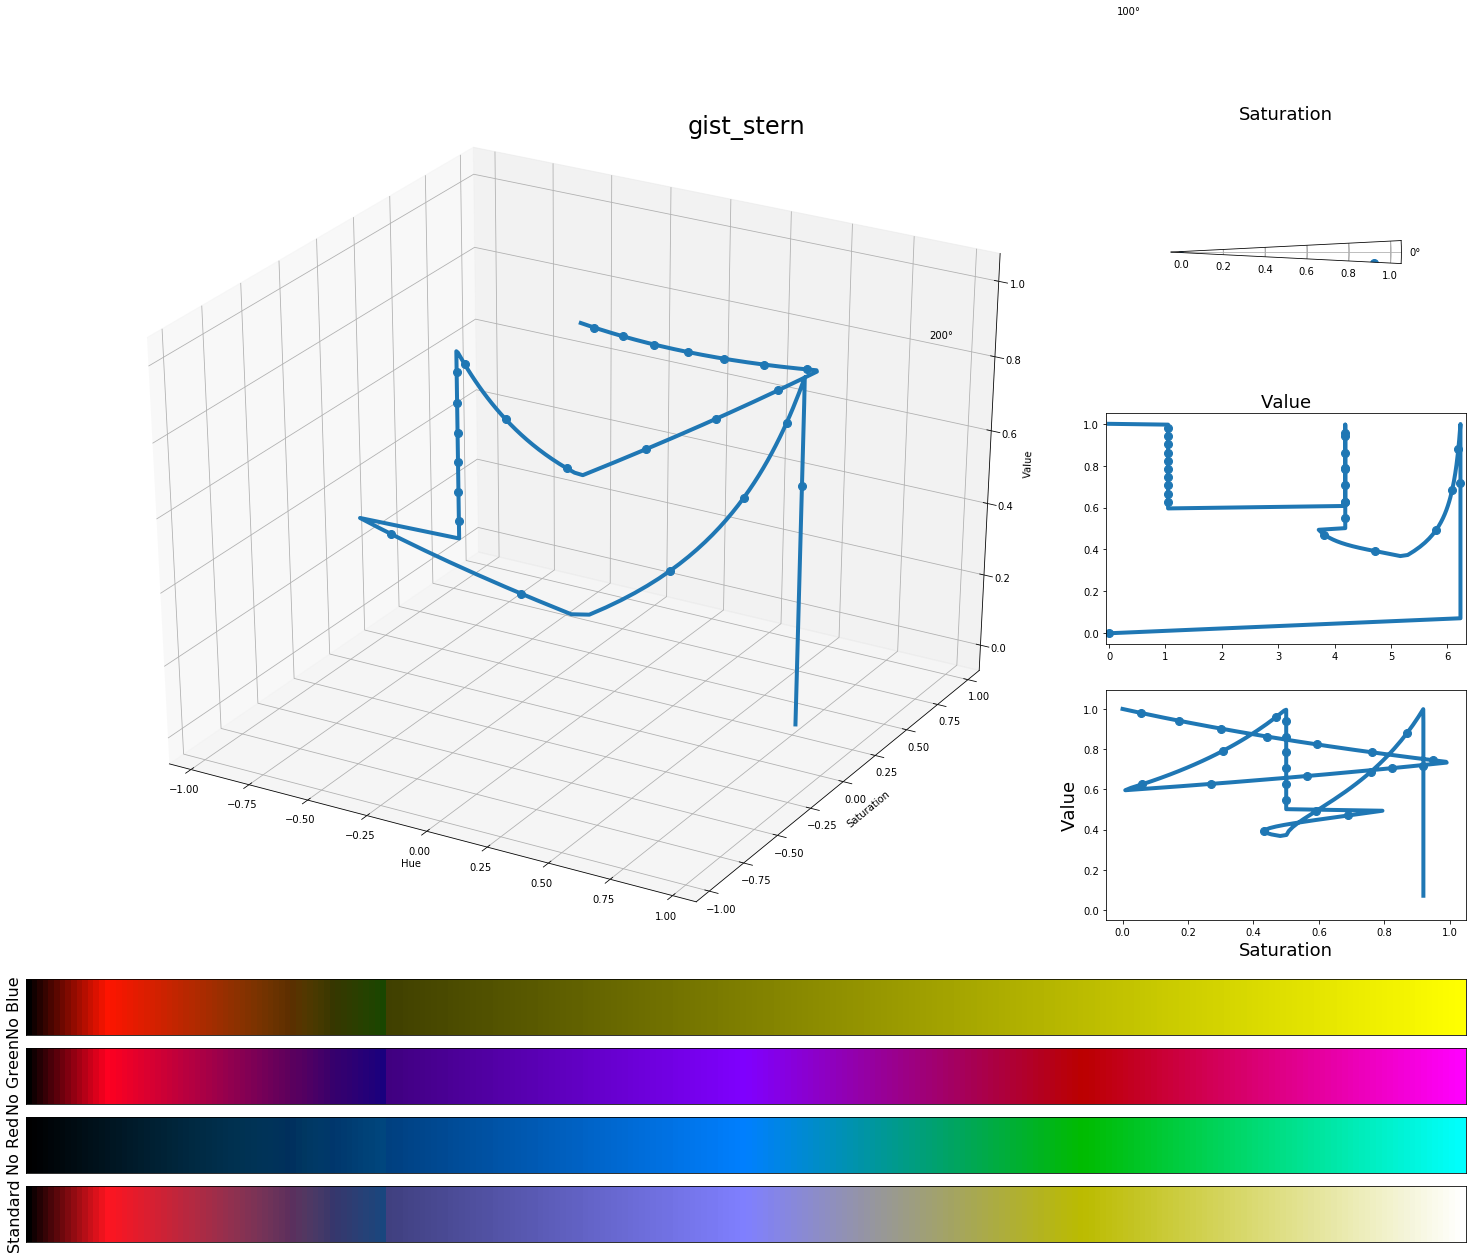

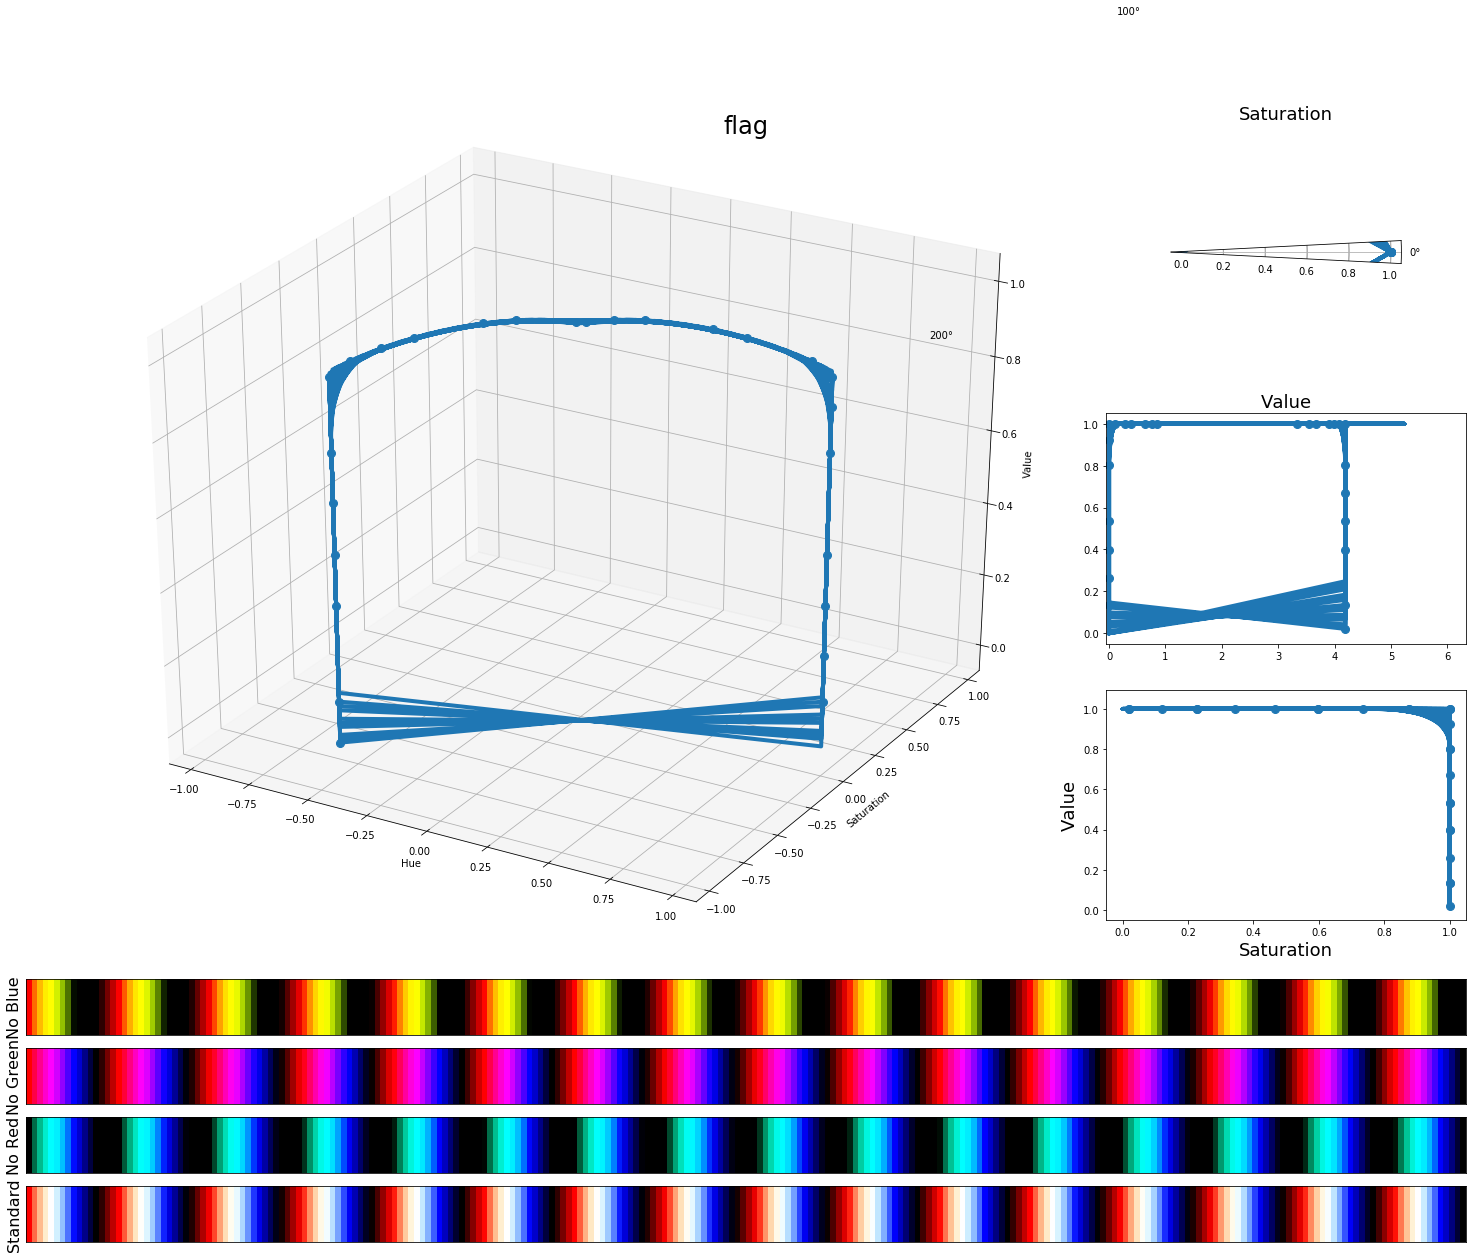

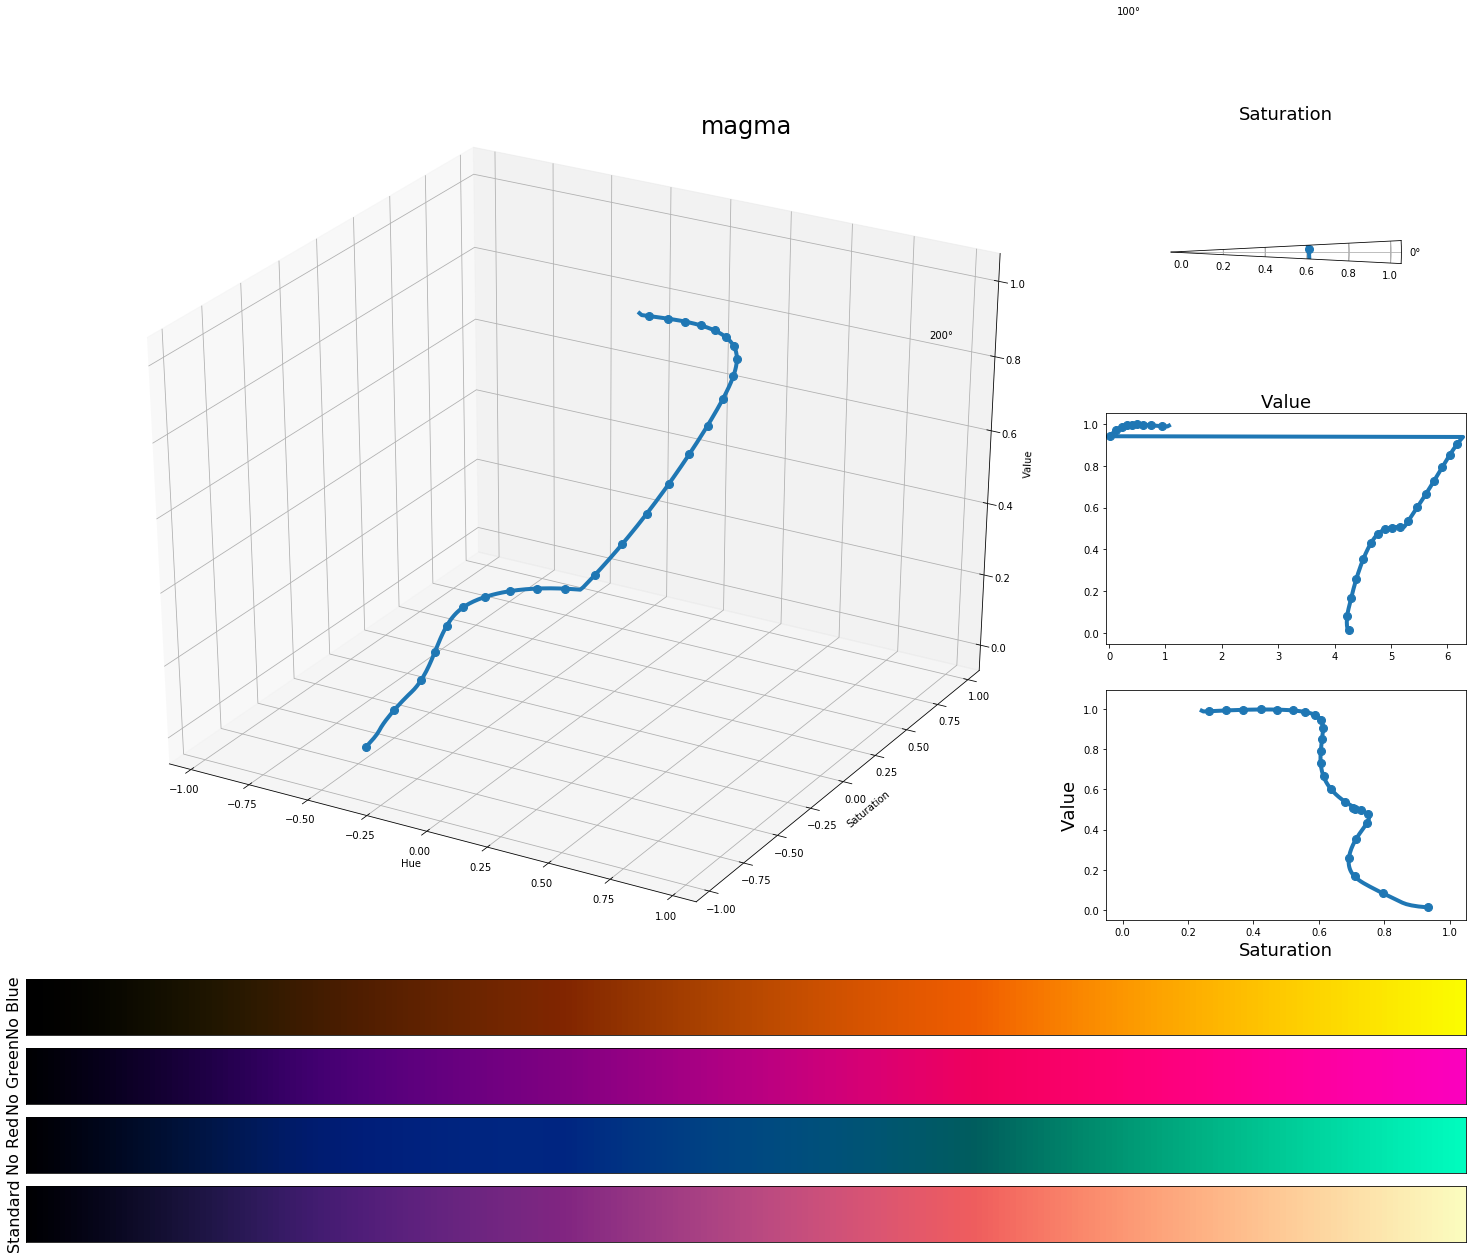

In [8]:
for c in ["viridis", "jet", "gray", "gist_stern", "flag", "magma"]:
    plot_colortable_hsv(c, name="images/%s_3d.png" % c)